In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newspaper-potrika/potrika-mini-10k.csv
/kaggle/input/newspaper-potrika/potrika-cleaned.csv
/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx
/kaggle/input/potrika-newspaper/potrika-mini-10k.csv
/kaggle/input/potrika-newspaper/patrika-re-cleaned.csv


# import required libraries

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Dropout, BatchNormalization,Dense,LSTM,GRU,Bidirectional,Embedding,Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

**This newspaper data set is already cleaned**

In [3]:
data = pd.read_csv('/kaggle/input/newspaper-potrika/potrika-mini-10k.csv')

In [4]:
data.head()

,article,class
0,আসরের তম ঢাকা আন্তর্জাতিক বাণিজ্য মেলায় স্টল ব...,Economy
1,সিকিউরিটিজ ভঙ্গ পুঁজিবাজারের কম্পানি ফুওয়াং ফু...,Economy
2,উখিয়া উপজেলা সংবাদদাতা নান্দনিক সৌন্দর্য্যরে ল...,Economy
3,পুঁজিবাজারের উন্নয়নে স্বল্প মূলধনী কোম্পানির প...,Economy
4,দেশের অর্থনীতির শতাংশই কালো টাকা বছরে বিদেশে প...,Economy


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  79999 non-null  object
 1   class    80000 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


**Oh no there is one null row......... let's remove it**

In [6]:
print(data[data['article'].isnull()])



      article     class
45373     NaN  National


In [7]:
data = data.dropna(subset=['article'])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 79999 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  79999 non-null  object
 1   class    79999 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


In [8]:
print(data[data['article'].isnull()])

Empty DataFrame
Columns: [article, class]
Index: []


In [9]:
data['class'].value_counts()

class
Economy               10000
Education             10000
Entertainment         10000
International         10000
Politics              10000
Science_Technology    10000
Sports                10000
National               9999
Name: count, dtype: int64

In [10]:
data['class'].unique()

array(['Economy', 'Education', 'Entertainment', 'International',
       'National', 'Politics', 'Science_Technology', 'Sports'],
      dtype=object)

*previously : array(['Economy', 'Education', 'Entertainment', 'International',
       'National', 'Politics', 'Science_Technology', 'Sports'],
      dtype=object)*

In [43]:
# Create a mapping dictionary for your categories
category_mapping = {
    'Economy': 0,
    'Education': 1,
    'Entertainment': 2,
    'International': 3,
    'Politics' :  4,
    'Science_Technology' : 5,
    'Sports' :  6,
    'National' : 7
   
}

# Apply the mapping to your dataframe
data['class'] = data['class'].map(category_mapping)

# Check if the mapping worked
print(data['class'].head(8))


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
Name: class, dtype: float64


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79999 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  79999 non-null  object
 1   class    79999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [13]:
data.head(100)

,article,class
0,আসরের তম ঢাকা আন্তর্জাতিক বাণিজ্য মেলায় স্টল ব...,0
1,সিকিউরিটিজ ভঙ্গ পুঁজিবাজারের কম্পানি ফুওয়াং ফু...,0
2,উখিয়া উপজেলা সংবাদদাতা নান্দনিক সৌন্দর্য্যরে ল...,0
3,পুঁজিবাজারের উন্নয়নে স্বল্প মূলধনী কোম্পানির প...,0
4,দেশের অর্থনীতির শতাংশই কালো টাকা বছরে বিদেশে প...,0
...,...,...
95,বসন্তবরণ ভ্যালেন্টাইনস ডে একুশে ফেব্রুয়ারি ঘির...,0
96,মূল্য সংযোজন কর সংশোধন জানিয়েছেন অর্থমন্ত্রী আ...,0
97,মোবাইল ফোন বিলাসী নিত্যপণ্য যায় সময়ের তাল মিলি...,0
98,শিবগঞ্জ উপজেলা সংবাদদাতাঃ সোনামসজিদ স্থলবন্দরে...,0


for demapping:

In [14]:
# reverse_mapping = {v: k for k, v in category_mapping.items()}

# # Apply reverse mapping
# filtered_df['category'] = filtered_df['category'].map(reverse_mapping)

# # Check the result
# print(filtered_df['category'].head())


# Tokenization and vectorization

**Let's find word frequency distribution**

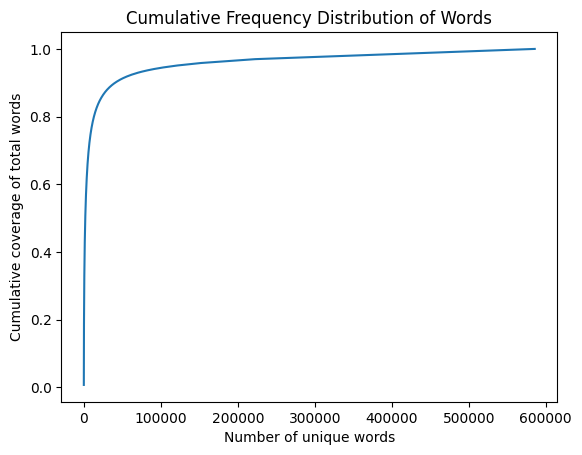

In [15]:
tk = Tokenizer()
tk.fit_on_texts(data['article'])

word_counts = tk.word_counts

sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the list of frequencies
frequencies = np.array([count for word, count in sorted_word_counts])

# Calculate cumulative frequency (percentage of total words captured)
cumulative_frequencies = np.cumsum(frequencies) / np.sum(frequencies)

# Plot the cumulative distribution
plt.plot(cumulative_frequencies)
plt.xlabel('Number of unique words')
plt.ylabel('Cumulative coverage of total words')
plt.title('Cumulative Frequency Distribution of Words')
plt.show()

In [16]:
# Inspect cumulative frequencies to decide on the number of words to keep
for i in [10000, 20000, 50000, 100000]:
    print(f"{i} words cover {cumulative_frequencies[i-1] * 100:.2f}% of the total text.")

10000 words cover 76.66% of the total text.
20000 words cover 84.42% of the total text.
50000 words cover 91.25% of the total text.
100000 words cover 94.42% of the total text.


In [17]:
 print(f"{41000} words cover {cumulative_frequencies[41000-1] * 100:.2f}% of the total text.")

41000 words cover 90.07% of the total text.


In [18]:
tk = Tokenizer(num_words=41000)
tk.fit_on_texts(data['article'])
seq = tk.texts_to_sequences(data['article'])

**to determine maxlen in padding let's do the following works**

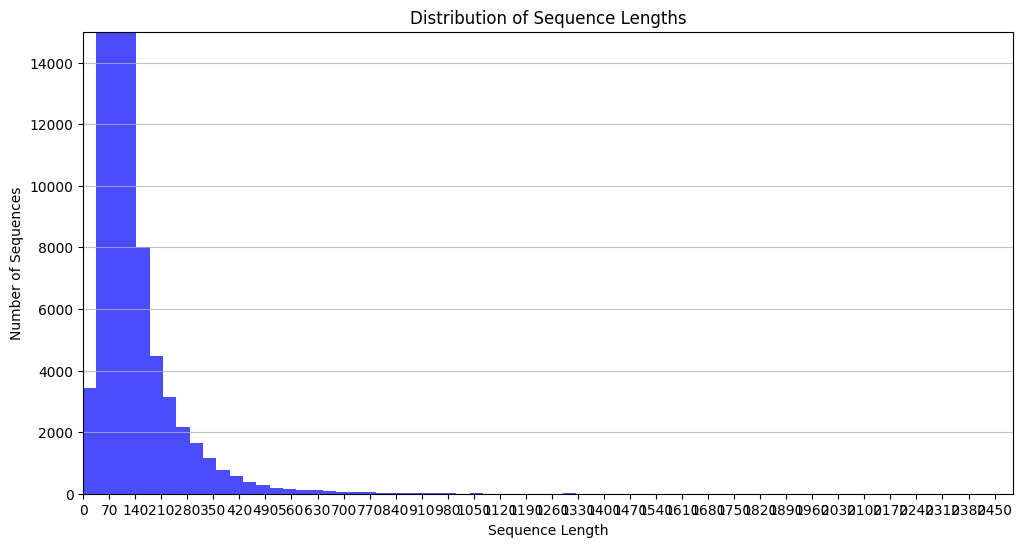

In [19]:
# Calculate sequence lengths
seq_lengths = [len(seq) for seq in seq]

# Plot the distribution of lengths
plt.figure(figsize=(12, 6))
plt.hist(seq_lengths, bins=70, color='blue', alpha=0.7)  


plt.xlim(0, 2500)  
plt.ylim(0, 15000)  

plt.xticks(np.arange(0, 2501, 70))  


plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

*It seems like maxlen = 150 in padding will be good. Let's see*

In [20]:
vec = pad_sequences(seq,padding='post',maxlen=140)

# encoding

In [21]:
data['class'].value_counts()

class
0    10000
1    10000
2    10000
3    10000
4    10000
5    10000
6    10000
7     9999
Name: count, dtype: int64

In [22]:
data['class'].unique()

array([0, 1, 2, 3, 7, 4, 5, 6])

# data splitting

In [23]:
labels = data['class']

In [24]:


# Split data into training + validation and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2, random_state=42)

# further split the training data into training and validation sets (e.g., 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Now you have:
# X_train, y_train: For training the model
# X_val, y_val: For validating the model during training
# X_test, y_test: For final testing after training


# **Model selection**

In [25]:


# let's Define the model
model1 = Sequential()

# Embedding layer
model1.add(Embedding(input_dim=len(tk.word_index) + 1, output_dim=100, input_length=200))

# Reduced Bidirectional LSTM layer with Dropout and Batch Normalization
# Decrease LSTM units from 512 to 128
model1.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model1.add(Dropout(0.6))  # Slightly increased dropout to prevent overfitting
model1.add(BatchNormalization())

# Flatten layer
model1.add(Flatten())

# Reduced Dense layers with Dropout
# Decrease Dense units from 256 to 64
model1.add(Dense(units=64, activation='relu'))
model1.add(Dropout(0.6))  # Slightly increased dropout to prevent overfitting
model1.add(BatchNormalization())

# Output layer
model1.add(Dense(units=8, activation='softmax'))  # Output layer with 10 units for classification

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



# Train the model with EarlyStopping
# Replace `X_train`, `y_train`, `X_val`, and `y_val` with your actual data
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[early_stopping])

# Print the model summary
model1.summary()

Epoch 1/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 85s 47ms/step - accuracy: 0.6700 - loss: 1.0323 - val_accuracy: 0.8770 - val_loss: 0.4000
Epoch 2/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - accuracy: 0.9086 - loss: 0.3260 - val_accuracy: 0.8821 - val_loss: 0.3938
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - accuracy: 0.9373 - loss: 0.2206 - val_accuracy: 0.8836 - val_loss: 0.4296
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - accuracy: 0.9574 - loss: 0.1435 - val_accuracy: 0.8769 - val_loss: 0.5407
Epoch 5/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 76s 47ms/step - accuracy: 0.9700 - loss: 0.1046 - val_accuracy: 0.8711 - val_loss: 0.6169


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 140, 100)       │    58,574,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 140, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 140, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 140, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 35840)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,293,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,313,782 (699.29 MB)

 Trainable params: 61,104,380 (233.09 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 122,208,762 (466.19 MB)

**much more simpler model is given below**

In [26]:


# Define the model
model2 = Sequential()

# Embedding layer
model2.add(Embedding(input_dim=len(tk.word_index) + 1, output_dim=100, input_length=200))

# GRU layer with Dropout and Batch Normalization
model2.add(GRU(units=128, return_sequences=False))  # Use GRU instead of LSTM and set return_sequences=False
model2.add(Dropout(0.6))  # Increased dropout to prevent overfitting
model2.add(BatchNormalization())

# Dense layers with Dropout
model2.add(Dense(units=64, activation='relu'))
model2.add(Dropout(0.6))  # Increased dropout
model2.add(BatchNormalization())

# Output layer
model2.add(Dense(units=8, activation='softmax'))  # Output layer with 8 units for classification

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[early_stopping])

# Print the model summary
model2.summary()


Epoch 1/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 70s 41ms/step - accuracy: 0.1629 - loss: 2.2663 - val_accuracy: 0.4938 - val_loss: 1.2895
Epoch 2/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.6083 - loss: 1.0665 - val_accuracy: 0.8240 - val_loss: 0.5599
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.8530 - loss: 0.5168 - val_accuracy: 0.8730 - val_loss: 0.4567
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 40ms/step - accuracy: 0.9119 - loss: 0.3448 - val_accuracy: 0.8782 - val_loss: 0.4611
Epoch 5/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 40ms/step - accuracy: 0.9444 - loss: 0.2303 - val_accuracy: 0.8772 - val_loss: 0.5224
Epoch 6/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 65s 40ms/step - accuracy: 0.9562 - loss: 0.1780 - val_accuracy: 0.8737 - val_loss: 0.5672


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 140, 100)       │    58,574,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,017,526 (671.45 MB)

 Trainable params: 58,672,380 (223.82 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 117,344,762 (447.63 MB)

In [27]:


# Define the model
model3 = Sequential()

# Embedding layer
model3.add(Embedding(input_dim=len(tk.word_index) + 1, output_dim=100, input_length=200))

# GRU layer with fewer units
model3.add(GRU(units=64, return_sequences=True))  # Reduced units from 128 to 64
model3.add(Dropout(0.6))  
model3.add(BatchNormalization())

# Flatten layer
model3.add(Flatten())

# Dense layer with fewer units
model3.add(Dense(units=32, activation='relu'))  # Reduced units from 64 to 32
model3.add(Dropout(0.6))  
model3.add(BatchNormalization())

# Output layer
model3.add(Dense(units=8, activation='softmax'))  

# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[early_stopping])

# Print the model summary
model3.summary()


Epoch 1/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 69s 40ms/step - accuracy: 0.4879 - loss: 1.5056 - val_accuracy: 0.8809 - val_loss: 0.4215
Epoch 2/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8451 - loss: 0.5354 - val_accuracy: 0.8699 - val_loss: 0.4480
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.8886 - loss: 0.3903 - val_accuracy: 0.8679 - val_loss: 0.4896
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.9098 - loss: 0.3109 - val_accuracy: 0.8697 - val_loss: 0.5390


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 140, 100)       │    58,574,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 140, 64)        │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 140, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       286,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,682,134 (673.99 MB)

 Trainable params: 58,893,980 (224.66 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 117,787,962 (449.33 MB)

> ***I think this model is better than the others***

# Evaluation & Performance measure

**model3**

In [28]:
model3.evaluate(X_test,y_test)

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8843 - loss: 0.4171


[0.41139161586761475, 0.8854374885559082]

In [29]:
y_pred = np.argmax(model3.predict(X_test), axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


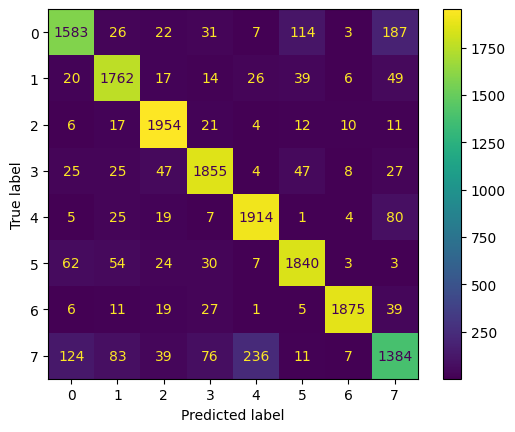

<Figure size 1000x800 with 0 Axes>

In [30]:
# Compute confusion matrix
cnf = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay(cnf).plot()
plt.figure(figsize=(10,8))
plt.show()

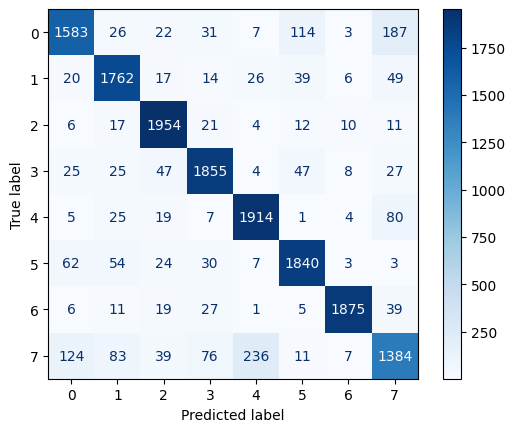

<Figure size 1000x800 with 0 Axes>

In [31]:
# y_pred is already a 1D array of predicted class labels
cnf = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
ConfusionMatrixDisplay(cnf).plot(cmap='Blues')

# Optionally, set the figure size
plt.figure(figsize=(10, 8))
plt.show()


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1973
           1       0.88      0.91      0.90      1933
           2       0.91      0.96      0.94      2035
           3       0.90      0.91      0.91      2038
           4       0.87      0.93      0.90      2055
           5       0.89      0.91      0.90      2023
           6       0.98      0.95      0.96      1983
           7       0.78      0.71      0.74      1960

    accuracy                           0.89     16000
   macro avg       0.88      0.88      0.88     16000
weighted avg       0.88      0.89      0.88     16000



**Oh ..  I see... for class 7 the model's performance is relatively poor :(**

**model2**

In [33]:
model2.evaluate(X_test,y_test)

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8772 - loss: 0.4417


[0.4343171715736389, 0.8783749938011169]

In [34]:
y_pred = np.argmax(model2.predict(X_test), axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


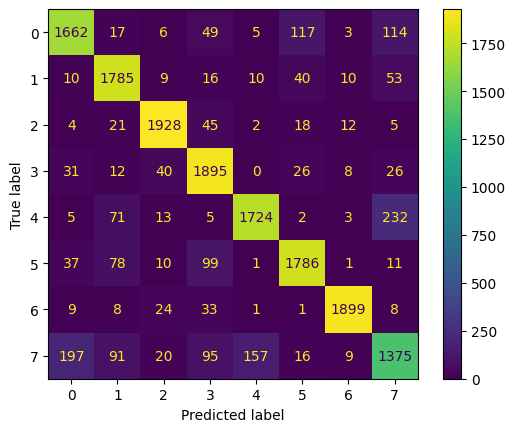

<Figure size 1000x800 with 0 Axes>

In [35]:
# Compute confusion matrix
cnf = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay(cnf).plot()
plt.figure(figsize=(10,8))
plt.show()

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1973
           1       0.86      0.92      0.89      1933
           2       0.94      0.95      0.94      2035
           3       0.85      0.93      0.89      2038
           4       0.91      0.84      0.87      2055
           5       0.89      0.88      0.89      2023
           6       0.98      0.96      0.97      1983
           7       0.75      0.70      0.73      1960

    accuracy                           0.88     16000
   macro avg       0.88      0.88      0.88     16000
weighted avg       0.88      0.88      0.88     16000



In [37]:
model1.evaluate(X_test,y_test)

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8807 - loss: 0.3879


[0.3893297016620636, 0.8817499876022339]

In [38]:
y_pred = np.argmax(model1.predict(X_test), axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


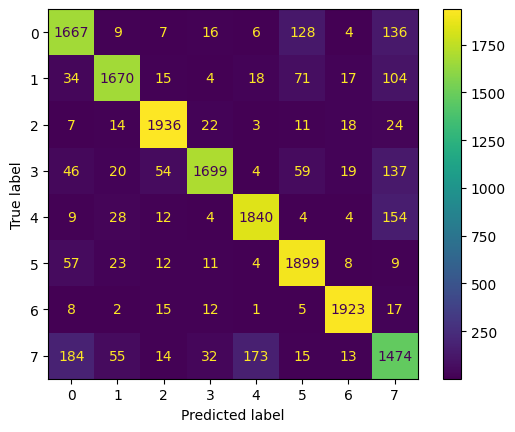

<Figure size 1000x800 with 0 Axes>

In [39]:
# Compute confusion matrix
cnf = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using ConfusionMatrixDisplay
ConfusionMatrixDisplay(cnf).plot()
plt.figure(figsize=(10,8))
plt.show()

In [40]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1973
           1       0.92      0.86      0.89      1933
           2       0.94      0.95      0.94      2035
           3       0.94      0.83      0.89      2038
           4       0.90      0.90      0.90      2055
           5       0.87      0.94      0.90      2023
           6       0.96      0.97      0.96      1983
           7       0.72      0.75      0.73      1960

    accuracy                           0.88     16000
   macro avg       0.88      0.88      0.88     16000
weighted avg       0.88      0.88      0.88     16000



**mmmmm...... I see... I'm gonna choose the model3 ...why? The relatively higher precision and f1 score**

# Save the better Models

In [41]:
model1.save('model1.h5') # let's save in  HDF5 format
model3.save('model3.h5')  

In [42]:
import tensorflow as tf
tf.saved_model.save(model3, 'exported_potrika_model3')  # let's also save in  SavedModel format
tf.saved_model.save(model1, 'exported_potrika_model1')  
